In [2]:
from openai import OpenAI
import random

client = OpenAI(api_key='')


In [3]:
import os
import json

email_dir = "data/Cater Mails/email threads"
gt_dir = "data/Cater Mails/ground truth"

os.makedirs(email_dir, exist_ok=True)
os.makedirs(gt_dir, exist_ok=True)

num_threads = 10

for i in range(11, 31):
    PROMPT_TEMPLATE = """
You are simulating a realistic business email exchange between:
- Food Supplier (Caterer)
- Event Organizer

Generate an email thread with exactly four messages. The final message must always be written by the Event Organizer.

CRITICAL WRITING RULES:
- Do NOT use placeholders, brackets, or template-style text.
- Always generate realistic personal names and company names.
- Do NOT use bullet points, numbered lists, bold text, headings, or markdown.
- Write only in natural business email prose, using full sentences and paragraphs.
- Do NOT explicitly label or name data fields.
- All details must be embedded naturally in the conversation.

CONTENT REQUIREMENTS:
Across the full email thread, the following information must be mentioned clearly
but implicitly, in natural language, so it can be inferred later:

- The type of event being catered.
- The pricing structure (per person, fixed price, or range).
- A concrete final price value if a deal is accepted.
- Minimum and maximum number of guests, if applicable.
- Whether VAT is included or added on top.
- Whether the food is kosher, and if so, under what supervision.
- Whether a bar or beverages are included or explicitly excluded.
- The general menu type (meat, dairy, mixed, pareve, or unclear).
- Available dietary accommodations.
- The event date.
- The cancellation terms.
- Representative menu items or dishes.
- Any additional relevant notes (timing, setup, staffing, equipment, etc.).

It is acceptable for some information to be omitted or left unclear if the context
naturally supports it.

Thread length rules:
- The email thread must have four messages.
- A short negotiation occurs in emails 2 and 3.
- The final email clearly accepts or cancels the agreement.

At the end of the email thread, output a JSON object containing all the features used in the thread.
Use the following keys exactly: 
event_type, price_type, final_price_value, min_guests, max_guests,
includes_vat, is_kosher, kosher_supervision, includes_bar,
menu_type, dietary_options, event_date, cancellation_policy,
menu_highlights, extra_notes
Use null for missing values. Do not add explanations or extra text. Separate the JSON from the email thread with a clear delimiter: "--- FEATURES JSON ---".

Output format:

Email 1 – Food Supplier:
<email>

Email 2 – Event Organizer:
<email>

Email 3 – Food Supplier:
<email>

Email 4 – Event Organizer:
<email>

--- FEATURES JSON ---
<JSON with all feature values>
"""
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": PROMPT_TEMPLATE}],
        temperature=0.7,
        max_tokens=1000
    )
    output_text = response.choices[0].message.content
    try:
        email_thread_text, features_json_text = output_text.split('--- FEATURES JSON ---')
        email_thread_text = email_thread_text.strip()
        features_json_text = features_json_text.strip()
        ground_truth_features = json.loads(features_json_text)
    except Exception as e:
        print(f"Error parsing thread {i}:", e)
        email_thread_text = output_text
        ground_truth_features = {"error": "Invalid JSON", "raw_output": output_text}
    
    email_file = os.path.join(email_dir, f"email_thread_{i:03d}.txt")
    json_file = os.path.join(gt_dir, f"ground_truth_{i:03d}.json")

    with open(email_file, "w", encoding="utf-8") as f:
        f.write(email_thread_text)
    
    with open(json_file, "w", encoding="utf-8") as f:
        json.dump(ground_truth_features, f, indent=2)


In [91]:
print("=== EMAIL THREAD ===")
print(email_thread_text)
print("\n=== FEATURES JSON ===")
print(json.dumps(ground_truth_features, indent=2))

=== EMAIL THREAD ===
Email 1 – Food Supplier:  
Subject: Catering Proposal for Your Upcoming Event  

Dear Sarah,  

Thank you for reaching out to us regarding your upcoming corporate gala on November 15th. We would be delighted to provide catering services for this event. Our menu features a variety of options, including a selection of meat and dairy dishes, all prepared under strict kosher supervision by the Orthodox Union.  

For your event, we typically charge $45 per person, which includes a full buffet setup, staff for serving, and all necessary equipment. This pricing is inclusive of VAT. We can accommodate between 50 to 150 guests, and we are happy to provide dietary options for any guests with specific needs.  

Please let me know if you would like to discuss the menu further or if you have any specific requests.  

Best regards,  
David Cohen  
Culinary Delights Catering  

Email 2 – Event Organizer:  
Subject: Re: Catering Proposal for Your Upcoming Event  

Hi David,  

Tha

In [4]:
import json
from sklearn.metrics import f1_score

pred_dir = "data/Cater Mails/extracted features zero-shot"

os.makedirs(pred_dir, exist_ok=True)

def extract_features_gpt4(email_thread: str):
    prompt = f"""
You are an expert information extraction system specialized in business email threads.  
Your task is to extract structured features **exactly in the JSON format below** from this email thread.  

Instructions:
- Output only valid JSON. Do not add explanations, comments, or extra text.  
- Use null for missing values.  
- Always return arrays for list fields, even if there is only one item.  
- Booleans must be true or false.  
- Strings must be concise and plain text, no extra punctuation or symbols.  
- For categorical fields, only use the specified exact values. Do not write synonyms.  
- Ensure date format is YYYY-MM-DD.  
- Only include items explicitly mentioned in the email thread.  

Required JSON format:
{{
  "event_type": "string or null",
  "price_type": "per_person | fixed | range | unknown",
  "final_price_value": number or null,
  "min_guests": number or null,
  "max_guests": number or null,
  "includes_vat": true | false | null,
  "is_kosher": true | false | null,
  "kosher_supervision": "string or null",
  "includes_bar": true | false | null,
  "menu_type": "meat | dairy | mixed | pareve | unknown",
  "dietary_options": ["array of strings"],
  "event_date": "YYYY-MM-DD or null",
  "cancellation_policy": "string or null",
  "menu_highlights": ["array of strings"],
  "extra_notes": "string or null"
}}

Extract these fields directly from the email thread below.  
For lists, include only the items actually mentioned. For categorical fields, only use the exact allowed values.  

Email thread:
{email_thread}
"""
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
        max_tokens=500
    )
    text = response.choices[0].message.content
    try:
        return json.loads(text)
    except json.JSONDecodeError:
        return {"error": "Invalid JSON", "raw_output": text}

for i in range(11, 31):
    email_file = os.path.join(email_dir, f"email_thread_{i:03d}.txt")
    json_file = os.path.join(pred_dir, f"extracted_features_{i:03d}.json")


    with open(email_file, "r", encoding="utf-8") as f:
        thread_text = f.read()

    predicted_features = extract_features_gpt4(thread_text)

    with open(json_file, "w", encoding="utf-8") as f:
        json.dump(predicted_features, f, indent=2)


In [93]:
print(json.dumps(predicted_features, indent=2))


{
  "event_type": "catering",
  "price_type": "fixed",
  "final_price_value": 4400,
  "min_guests": 50,
  "max_guests": 100,
  "includes_vat": true,
  "is_kosher": true,
  "kosher_supervision": "Orthodox Union",
  "includes_bar": true,
  "menu_type": "mixed",
  "dietary_options": [
    "vegetarian",
    "dietary restrictions"
  ],
  "event_date": "2023-06-15",
  "cancellation_policy": "10 days prior to the event",
  "menu_highlights": [
    "herb-roasted chicken",
    "grilled vegetable platters",
    "variety of salads",
    "stuffed bell peppers",
    "pasta dishes"
  ],
  "extra_notes": "point person from catering team present during the event"
}


In [5]:
from collections import defaultdict

BASE_DIR = "data/Cater Mails"
PRED_DIR = os.path.join(BASE_DIR, "extracted features zero-shot")
GOLD_DIR = os.path.join(BASE_DIR, "ground truth")

BOOLEAN_FIELDS = {"includes_vat", "is_kosher", "includes_bar"}
CATEGORICAL_FIELDS = {"price_type", "menu_type"}
LIST_FIELDS = {"dietary_options", "menu_highlights"}

def normalize(value):
    if value is None:
        return None
    if isinstance(value, str):
        return value.strip().lower()
    if isinstance(value, list):
        return [str(x).strip().lower() for x in value]
    return value

def convert_to_list(value):
    """Ensure the value is a list for list fields, even if originally a string"""
    if value is None:
        return []
    if isinstance(value, list):
        return normalize(value)
    return [normalize(value)]

def list_overlap_score(pred_list, gold_list):
    """Compute Jaccard-like overlap score between two lists"""
    pred_set = set(pred_list)
    gold_set = set(gold_list)
    if not gold_set:
        return 1.0 if not pred_set else 0.0
    return len(pred_set & gold_set) / len(gold_set)

def evaluate(pred, gold):
    results = {}
    exact_matches = []

    # Compare all fields
    for key in gold:
        g = gold.get(key)
        p = pred.get(key)

        if key in LIST_FIELDS:
            g_list = convert_to_list(g)
            p_list = convert_to_list(p)
            score = list_overlap_score(p_list, g_list)
            exact_matches.append(score)
        else:
            g_norm = normalize(g)
            p_norm = normalize(p)
            exact_matches.append(p_norm == g_norm)

    # Overall exact match: average score across all fields
    results["exact_match_rate"] = sum([1 if x is True else x for x in exact_matches]) / len(exact_matches)

    # Categorical F1 for flat string fields
    y_true = []
    y_pred = []
    for key in CATEGORICAL_FIELDS:
        g_val = normalize(gold.get(key))
        p_val = normalize(pred.get(key))
        if g_val is not None and p_val is not None:
            y_true.append(g_val)
            y_pred.append(p_val)

    if y_true:
        results["categorical_f1"] = f1_score(y_true, y_pred, average="macro", zero_division=0)
    else:
        results["categorical_f1"] = None

    return results

In [6]:
all_results = []
per_field_scores = defaultdict(list)

for i in range(1, 31):  # 001–030
    pred_file = os.path.join(PRED_DIR, f"extracted_features_{i:03d}.json")
    gold_file = os.path.join(GOLD_DIR, f"ground_truth_{i:03d}.json")

    try:
        with open(pred_file, "r", encoding="utf-8") as f:
            pred = json.load(f)
        with open(gold_file, "r", encoding="utf-8") as f:
            gold = json.load(f)

        result = evaluate(pred, gold)
        all_results.append(result)
        print(f"Thread {i:03d} evaluation:", result)

        # ---- PER-FIELD ANALYSIS (EDA) ----
        for key in gold:
            g = gold.get(key)
            p = pred.get(key)

            if key in LIST_FIELDS:
                g_list = convert_to_list(g)
                p_list = convert_to_list(p)
                score = list_overlap_score(p_list, g_list)
                per_field_scores[key].append(score)
            else:
                per_field_scores[key].append(normalize(p) == normalize(g))

    except Exception as e:
        print(f"Error evaluating thread {i:03d}: {e}")


# Optionally, compute average across all threads
if all_results:
    avg_exact = sum(r["exact_match_rate"] for r in all_results) / len(all_results)
    avg_f1 = sum(r["categorical_f1"] for r in all_results if r["categorical_f1"] is not None) / len(
        [r for r in all_results if r["categorical_f1"] is not None])
    print("Average exact match rate:", avg_exact)
    print("Average categorical F1:", avg_f1)

Thread 001 evaluation: {'exact_match_rate': 0.7333333333333333, 'categorical_f1': 0.3333333333333333}
Thread 002 evaluation: {'exact_match_rate': 0.6, 'categorical_f1': 0.3333333333333333}
Thread 003 evaluation: {'exact_match_rate': 0.7777777777777778, 'categorical_f1': 0.3333333333333333}
Thread 004 evaluation: {'exact_match_rate': 0.6, 'categorical_f1': 0.3333333333333333}
Thread 005 evaluation: {'exact_match_rate': 0.9333333333333333, 'categorical_f1': 0.3333333333333333}
Thread 006 evaluation: {'exact_match_rate': 0.5333333333333333, 'categorical_f1': 0.3333333333333333}
Thread 007 evaluation: {'exact_match_rate': 0.6666666666666666, 'categorical_f1': 0.3333333333333333}
Thread 008 evaluation: {'exact_match_rate': 0.7166666666666667, 'categorical_f1': 0.3333333333333333}
Thread 009 evaluation: {'exact_match_rate': 0.6666666666666666, 'categorical_f1': 0.3333333333333333}
Thread 010 evaluation: {'exact_match_rate': 0.6, 'categorical_f1': 0.3333333333333333}
Thread 011 evaluation: {'

In [95]:
metrics = evaluate(predicted_features, ground_truth_features)
print(metrics)


{'exact_match_rate': 0.3333333333333333, 'categorical_f1': 0.3333333333333333}


In [7]:
print("\n=== FEATURE-LEVEL PERFORMANCE ===")

feature_summary = {}

for field, scores in per_field_scores.items():
    numeric_scores = [
        1 if s is True else 0 if s is False else s
        for s in scores
    ]
    avg_score = sum(numeric_scores) / len(numeric_scores)
    feature_summary[field] = avg_score
    print(f"{field:25s} → {avg_score:.3f}")



=== FEATURE-LEVEL PERFORMANCE ===
event_type                → 0.833
price_type                → 0.000
final_price_value         → 0.700
min_guests                → 0.933
max_guests                → 0.967
includes_vat              → 1.000
is_kosher                 → 1.000
kosher_supervision        → 1.000
includes_bar              → 0.800
menu_type                 → 1.000
dietary_options           → 0.167
event_date                → 0.533
cancellation_policy       → 0.633
menu_highlights           → 0.302
extra_notes               → 0.467


In [9]:
print("\n=== BEST FEATURES ===")
for k, v in sorted(feature_summary.items(), key=lambda x: x[1], reverse=True):
    print(f"{k:25s} → {v:.3f}")



=== BEST FEATURES ===
includes_vat              → 1.000
is_kosher                 → 1.000
kosher_supervision        → 1.000
menu_type                 → 1.000
max_guests                → 0.967
min_guests                → 0.933
event_type                → 0.833
includes_bar              → 0.800
final_price_value         → 0.700
cancellation_policy       → 0.633
event_date                → 0.533
extra_notes               → 0.467
menu_highlights           → 0.302
dietary_options           → 0.167
price_type                → 0.000


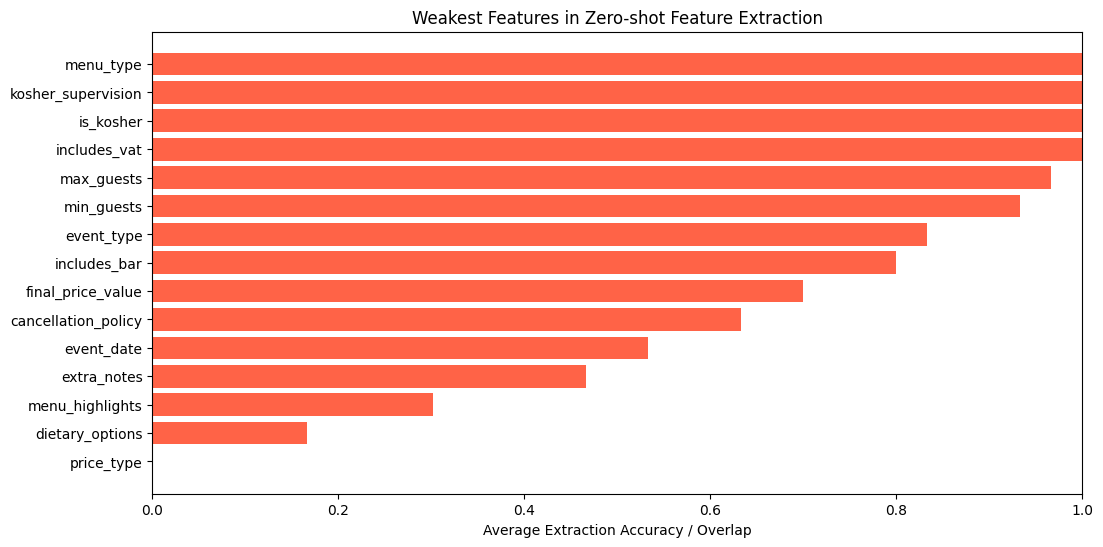

In [11]:
import matplotlib.pyplot as plt

# Sort by score ascending (worst first)
sorted_fields = sorted(feature_summary.items(), key=lambda x: x[1])
fields_sorted, scores_sorted = zip(*sorted_fields)

plt.figure(figsize=(12,6))
plt.barh(fields_sorted, scores_sorted, color='tomato')
plt.xlabel("Average Extraction Accuracy / Overlap")
plt.title("Weakest Features in Zero-shot Feature Extraction")
plt.xlim(0,1)
plt.show()

In [43]:
import os
import re
import json
from gliner import GLiNER

# Make sure paths exist
os.makedirs("data/Cater Mails/email threads", exist_ok=True)
os.makedirs("data/Cater Mails/ground_truth", exist_ok=True)
os.makedirs("data/Cater Mails/extracted_features", exist_ok=True)


In [51]:
LABELS = {
    "event_type": "Words like wedding, gala, conference, party",
    "price_type": "Look for phrases: per person, fixed price, range",
    "final_price_value": "Numbers with $ or currency symbols",
    "min_guests": "Phrases like minimum 50 guests",
    "max_guests": "Phrases like maximum 200 guests",
    "includes_vat": "Contains VAT included or excluded",
    "is_kosher": "Mentions kosher food",
    "kosher_supervision": "Mentions Orthodox Union or other supervision",
    "includes_bar": "Mentions bar, beverages included or excluded",
    "menu_type": "Look for meat, dairy, mixed, pareve",
    "dietary_options": "Vegetarian, vegan, gluten-free etc.",
    "event_date": "Dates in any format",
    "cancellation_policy": "Words like cancellation, refund",
    "menu_highlights": "Specific dishes mentioned",
    "extra_notes": "Anything extra mentioned"
}


In [52]:
def extract_first_last_email(thread_text: str):
    # Split by email markers
    emails = re.split(r"Email \d+ – (?:Food Supplier|Event Organizer):", thread_text)
    emails = [e.strip() for e in emails if e.strip()]
    if not emails:
        return "", ""
    return emails[0], emails[-1]


In [53]:
# Load GLiNER model
model = GLiNER.from_pretrained("urchade/gliner_medium")

def predict_features(thread_text):
    first_email, last_email = extract_first_last_email(thread_text)
    text = first_email + "\n" + last_email

    raw_entities = model.predict_entities(text, LABELS)

    # Deduplicate by (label, text)
    seen = {}
    for e in raw_entities:
        key = (e["label"], e["text"].lower())
        seen[key] = e
    raw_entities = list(seen.values())

    # Map entities to required JSON
    features = {
        "event_type": None,
        "price_type": None,
        "final_price_value": None,
        "min_guests": None,
        "max_guests": None,
        "includes_vat": None,
        "is_kosher": None,
        "kosher_supervision": None,
        "includes_bar": None,
        "menu_type": None,
        "dietary_options": [],
        "event_date": None,
        "cancellation_policy": None,
        "menu_highlights": [],
        "extra_notes": None
    }

    for e in raw_entities:
        label = e["label"].upper()
        text_val = e["text"].strip()
        if label in ["DIETARY_OPTIONS", "MENU_HIGHLIGHTS"]:
            features[label.lower()] = list(set(features[label.lower()]) | {text_val})
        elif label in features:
            features[label.lower()] = text_val

    return features


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

In [54]:
from sklearn.metrics import f1_score

LIST_FIELDS = {"dietary_options", "menu_highlights"}
CATEGORICAL_FIELDS = {"price_type", "menu_type"}

def normalize(value):
    if value is None:
        return None
    if isinstance(value, str):
        return value.strip().lower()
    if isinstance(value, list):
        return [str(x).strip().lower() for x in value]
    return value

def convert_to_list(value):
    if value is None:
        return []
    if isinstance(value, list):
        return normalize(value)
    return [normalize(value)]

def list_overlap_score(pred_list, gold_list):
    pred_set = set(pred_list)
    gold_set = set(gold_list)
    if not gold_set:
        return 1.0 if not pred_set else 0.0
    return len(pred_set & gold_set) / len(gold_set)

def evaluate(pred, gold):
    exact_matches = []
    for key in gold:
        g = gold.get(key)
        p = pred.get(key)
        if key in LIST_FIELDS:
            score = list_overlap_score(convert_to_list(p), convert_to_list(g))
            exact_matches.append(score)
        else:
            exact_matches.append(normalize(p) == normalize(g))
    exact_match_rate = sum([1 if x is True else x for x in exact_matches]) / len(exact_matches)

    # F1 for categorical fields
    y_true, y_pred = [], []
    for key in CATEGORICAL_FIELDS:
        g_val = normalize(gold.get(key))
        p_val = normalize(pred.get(key))
        if g_val is not None and p_val is not None:
            y_true.append(g_val)
            y_pred.append(p_val)
    categorical_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0) if y_true else None

    return {"exact_match_rate": exact_match_rate, "categorical_f1": categorical_f1}


In [60]:
num_threads = 30
all_results = []

for i in range(1, num_threads + 1):
    email_file = f"data/Cater Mails/email threads/email_thread_{i:03d}.txt"
    gold_file = f"data/Cater Mails/ground truth/ground_truth_{i:03d}.json"
    pred_file = f"data/Cater Mails/extracted_features/predicted_{i:03d}.json"

    with open(email_file, "r", encoding="utf-8") as f:
        thread_text = f.read()
    with open(gold_file, "r", encoding="utf-8") as f:
        ground_truth = json.load(f)

    predicted = predict_features(thread_text)

    # Save prediction
    with open(pred_file, "w", encoding="utf-8") as f:
        json.dump(predicted, f, indent=2)

    result = evaluate(predicted, ground_truth)
    all_results.append(result)

# Average across threads
avg_exact = sum(r["exact_match_rate"] for r in all_results) / len(all_results)
print("Average exact match rate:", avg_exact)


Average exact match rate: 0.05999999999999999


**Observation:** The overall scores are very low.  

The main reason is that the GLiNER model output often does not align with the required JSON format.  
This mismatch during post-processing leads to missing or incorrectly mapped fields, which drastically reduces the exact match and categorical F1 scores.